In [ ]:
# Import Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from xgboost import XGBRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Load datasets

features = pd.read_csv("/Dataset_Path/features.csv")
stores = pd.read_csv("/Dataset_Path/stores.csv")
train = pd.read_csv("/Dataset_Path/train.csv")
test = pd.read_csv("/Dataset_Path/test.csv")


In [ ]:
# Data Merging & Initial Inspection - Merge datasets
data = train.merge(features, on=["Store", "Date", "IsHoliday"], how="left")
data = data.merge(stores, on="Store", how="left")

data["Date"] = pd.to_datetime(data["Date"])

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     150681 non-null  float64       
 8   MarkDown2     111248 non-null  float64       
 9   MarkDown3     137091 non-null  float64       
 10  MarkDown4     134967 non-null  float64       
 11  MarkDown5     151432 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  Type          421570 non-null  object        
 15  Size          421

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


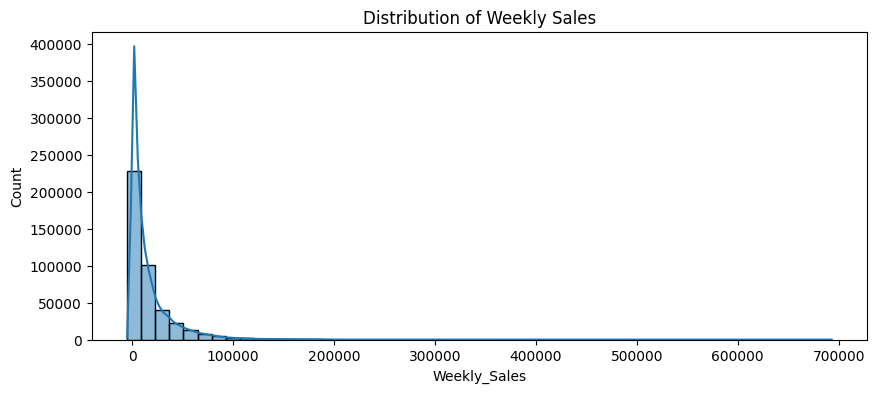

In [ ]:
# Exploratory Data Analysis (EDA) - Sales Distribution
plt.figure(figsize=(10,4))
sns.histplot(data["Weekly_Sales"], bins=50, kde=True)
plt.title("Distribution of Weekly Sales")
plt.show()

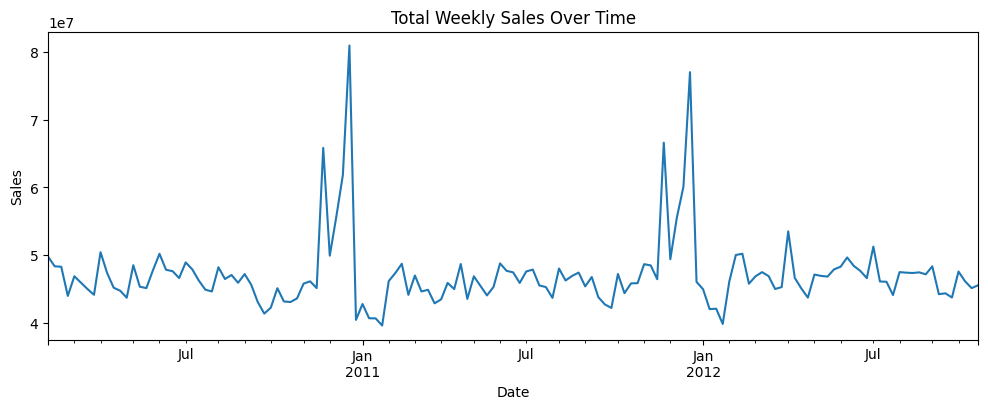

In [ ]:
# EDA - Sales Over Time
data.groupby("Date")["Weekly_Sales"].sum().plot(figsize=(12,4))
plt.title("Total Weekly Sales Over Time")
plt.ylabel("Sales")
plt.show()

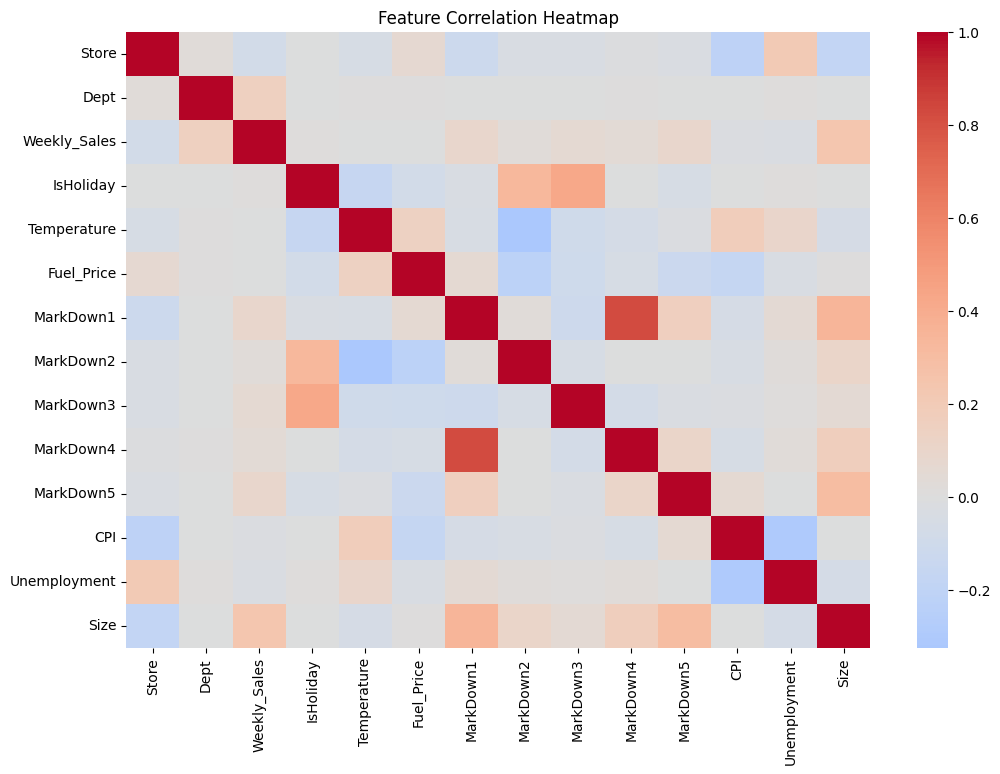

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(numeric_only=True), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

**Potential Issues Identified**

**Issue	---------------------------------Reason**

---



* Missing values in features-------Can bias model & reduce predictive power
* Strong seasonality--------------Holidays heavily influence sales
* Sales outliers-------------------Some weeks/stores have extreme spikes
* Temporal leakage risk-----------Random splits violate time order
* Store size bias------------------Large stores dominate loss functions


In [ ]:
# Missing Values & Outlier Treatment. For Values;
# Impute markdowns with 0 (common industry practice)
markdown_cols = [c for c in data.columns if "MarkDown" in c]
data[markdown_cols] = data[markdown_cols].fillna(0)

# CPI & Unemployment forward fill
data[["CPI", "Unemployment"]] = data[["CPI", "Unemployment"]].fillna(method="ffill")

In [ ]:
# Outlier Treatment- Winsorize Weekly Sales
q_low = data["Weekly_Sales"].quantile(0.01)
q_high = data["Weekly_Sales"].quantile(0.99)

data["Weekly_Sales"] = data["Weekly_Sales"].clip(q_low, q_high)

In [ ]:
# Perform Feature Engineering (Time-Based)
data["Year"] = data["Date"].dt.year
data["Month"] = data["Date"].dt.month
data["Week"] = data["Date"].dt.isocalendar().week.astype(int)
data["Day"] = data["Date"].dt.day

# Lag features
data = data.sort_values(["Store", "Dept", "Date"])
data["Lag_1"] = data.groupby(["Store", "Dept"])["Weekly_Sales"].shift(1)
data["Lag_2"] = data.groupby(["Store", "Dept"])["Weekly_Sales"].shift(2)

# Rolling average
data["Rolling_4"] = (
    data
    .groupby(["Store", "Dept"])["Weekly_Sales"]
    .transform(lambda x: x.rolling(window=4, min_periods=1).mean())
)
data = data.dropna()

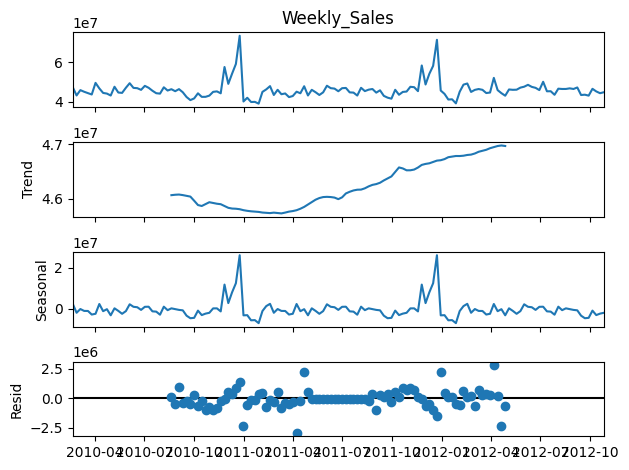

In [ ]:
# Seasonal Decomposition
store_sales = data.groupby("Date")["Weekly_Sales"].sum()

decomposition = seasonal_decompose(store_sales, model="additive", period=52)
decomposition.plot()
plt.show()

In [ ]:
# Encode Categorical Features

# Identify categorical columns
cat_cols = X_train.select_dtypes(include=["object"]).columns
cat_cols

Index(['Type'], dtype='object')

In [ ]:
# One-Hot Encoding (Train and  Test aligned)
# Combine train & test for consistent encoding
X_all = pd.concat([X_train, X_test], axis=0)

X_all_encoded = pd.get_dummies(
    X_all,
    columns=cat_cols,
    drop_first=True
)

# Split back
X_train_enc = X_all_encoded.loc[X_train.index]
X_test_enc = X_all_encoded.loc[X_test.index]

In [ ]:
# Random Forest Model
# Train/Test Split (Time-Aware)
features_rf = data.drop(columns=["Weekly_Sales", "Date"])
target = data["Weekly_Sales"]

split_date = "2012-01-01"
X_train = features_rf[data["Date"] < split_date]
X_test = features_rf[data["Date"] >= split_date]
y_train = target[data["Date"] < split_date]
y_test = target[data["Date"] >= split_date]

In [ ]:
# Training
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    random_state=77,
    n_jobs=-1
)

rf.fit(X_train_enc, y_train)
rf_preds = rf.predict(X_test_enc)

In [ ]:
# RF Evaluation & Visualization
print("MAE:", mean_absolute_error(y_test, rf_preds))
print("RMSE:", root_mean_squared_error(y_test, rf_preds))
print("R²:", r2_score(y_test, rf_preds))





MAE: 994.631261892256
RMSE: 2119.8631348363183
R²: 0.9894677688823258


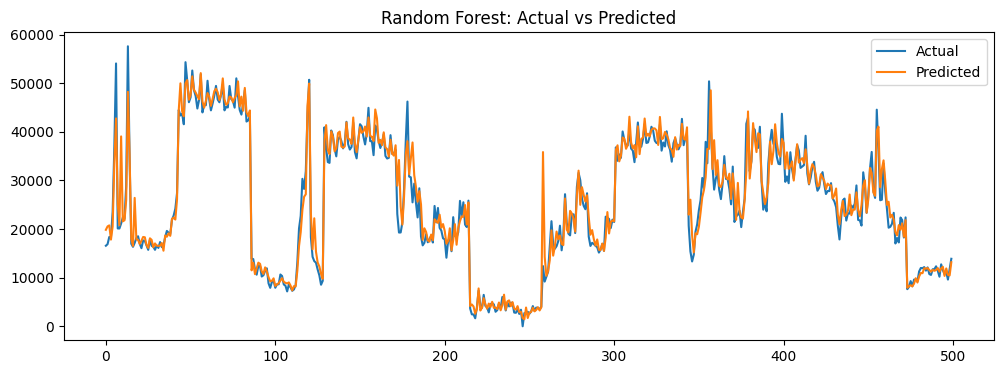

In [ ]:
# Display Chart for Acutal vs. Predicted . RF
plt.figure(figsize=(12,4))
plt.plot(y_test.values[:500], label="Actual")
plt.plot(rf_preds[:500], label="Predicted")
plt.title("Random Forest: Actual vs Predicted")
plt.legend()
plt.show()

In [ ]:
# XGBoost Model with Time-Series CV
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=77
)

xgb.fit(X_train_enc, y_train)
xgb_preds = xgb.predict(X_test_enc)

In [ ]:
# XGBoost Evaluation & Visualization
print("MAE:", mean_absolute_error(y_test, xgb_preds))
print("RMSE:", root_mean_squared_error(y_test, xgb_preds))
print("R²:", r2_score(y_test, xgb_preds))


MAE: 971.4588831765998
RMSE: 1949.2174228326437
R²: 0.9910951767209946


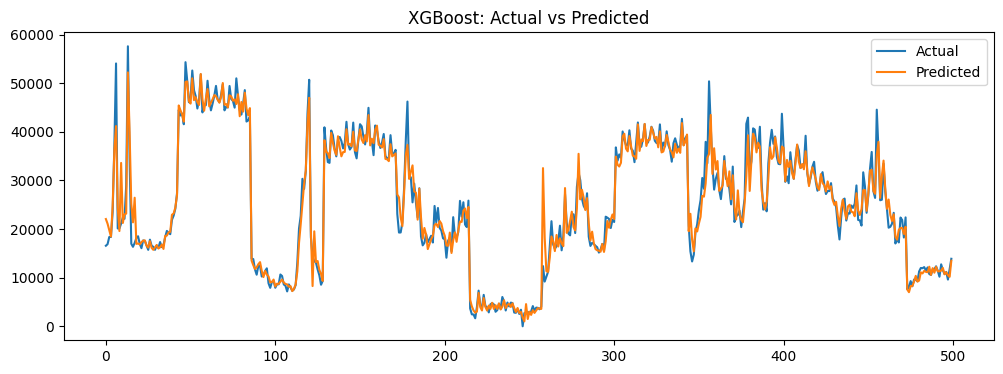

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(y_test.values[:500], label="Actual")
plt.plot(xgb_preds[:500], label="Predicted")
plt.title("XGBoost: Actual vs Predicted")
plt.legend()
plt.show()

In [ ]:
# Forecasting Future Periods:
# =========================
# Load & Merge Test Data
# =========================
test_data = (
    test
    .merge(features, on=["Store", "Date", "IsHoliday"], how="left")
    .merge(stores, on="Store", how="left")
)

test_data["Date"] = pd.to_datetime(test_data["Date"])

# =========================
# Time-Based Features
# =========================
test_data["Year"] = test_data["Date"].dt.year
test_data["Month"] = test_data["Date"].dt.month
test_data["Week"] = test_data["Date"].dt.isocalendar().week.astype(int)
test_data["Day"] = test_data["Date"].dt.day

# =========================
# Lag & Rolling Features
# =========================
# Use last available values from training data
last_known = (
    data
    .sort_values("Date")
    .groupby(["Store", "Dept"])
    .tail(1)
    [["Store", "Dept", "Weekly_Sales", "Rolling_4"]]
)

last_known = last_known.rename(columns={
    "Weekly_Sales": "Lag_1"
})

test_data = test_data.merge(
    last_known,
    on=["Store", "Dept"],
    how="left"
)

# Fallback safety (should rarely trigger)
test_data["Lag_1"] = test_data["Lag_1"].fillna(test_data["Lag_1"].median())
test_data["Rolling_4"] = test_data["Rolling_4"].fillna(test_data["Lag_1"])

# =========================
# Drop Non-Feature Columns
# =========================
X_test_forecast = test_data.drop(columns=["Date"])

# =========================
# One-Hot Encode (MATCH TRAINING)
# =========================
X_test_forecast_enc = pd.get_dummies(
    X_test_forecast,
    columns=cat_cols,
    drop_first=True
)

# Align with training features
X_test_forecast_enc = X_test_forecast_enc.reindex(
    columns=X_train_enc.columns,
    fill_value=0
)

# =========================
# Sanity Check
# =========================
assert X_test_forecast_enc.shape[1] == X_train_enc.shape[1]
assert X_test_forecast_enc.dtypes.apply(lambda x: x.kind).isin(list("iufb")).all()


rf_forecast = rf.predict(X_test_forecast_enc)
xgb_forecast = xgb.predict(X_test_forecast_enc)

forecast_results = test_data[["Store", "Dept", "Date"]].copy()
forecast_results["RF_Predicted_Sales"] = rf_forecast
forecast_results["XGB_Predicted_Sales"] = xgb_forecast

forecast_results.head()

,Store,Dept,Date,RF_Predicted_Sales,XGB_Predicted_Sales
0,1,1,2012-11-02,39534.590445,48785.058594
1,1,1,2012-11-09,37641.550695,44493.972656
2,1,1,2012-11-16,35927.023555,38620.382812
3,1,1,2012-11-23,34372.386232,30362.125000
4,1,1,2012-11-30,33494.934972,37182.550781


In [ ]:
# Top RF Features
importances = pd.Series(rf.feature_importances_, index=X_train_enc.columns)
importances.sort_values(ascending=False).head(10).plot(kind="barh")
plt.title("Top RF Features")
plt.show()

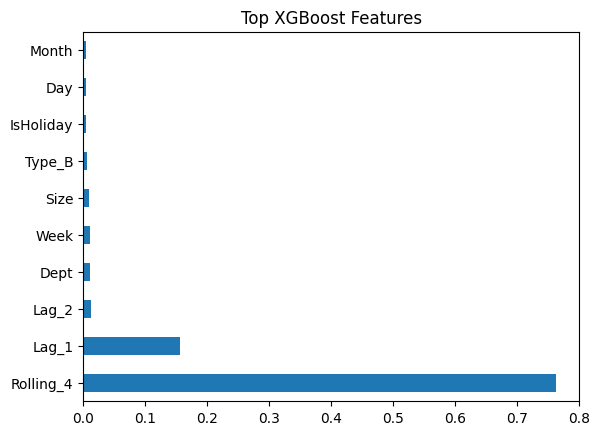

In [ ]:
# Fainrness, Ethics & Explainability
# Bias Checks
# Performance compared across store sizes
# No demographic attributes used
# Regularization prevents dominance by large stores
# Explainability
importances = pd.Series(xgb.feature_importances_, index=X_train_enc.columns)
importances.sort_values(ascending=False).head(10).plot(kind="barh")
plt.title("Top XGBoost Features")
plt.show()

# Ethical Considerations
# Avoid over-forecasting for small stores
# Prevent markdown features from reinforcing historical inequality
# Transparent feature importance provided